In [1]:
#pip install opencv-python

In [2]:
# imports
import numpy as np
import skimage
from scipy import misc
from scipy import ndimage
import cv2
import os
from os import listdir
from os.path import isfile, join
import math
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import tensorflow as tf
import pickle
from random import randrange


# Prétraitement

In [3]:
def disp_img(images, rows = 1, h=30, w=20, cmap = 'viridis') :
    fig=plt.figure(figsize=(h, w))
    columns = math.ceil(len(images)/rows)    
    spec = gridspec.GridSpec(ncols=columns, nrows=rows, figure=fig)
    for i in range(0, len(images)):
        img = images[i]
        fig.add_subplot(spec[math.floor(i/columns), i%columns])
        plt.axis('off')
        plt.imshow(img, cmap = cmap)
    plt.show()

In [4]:
def apply_normalize(img, show_working_out = False):
    normalized_img = cv2.normalize(img, None, 255, 255, cv2.NORM_INF)
    if(show_working_out) :
        print("Histogramme de base")
        histo1 = plt.hist(img.ravel(),256,[0,256],alpha=0.5,label="original");
        plt.show()
        print("Histogramme normalisé")
        histo2 = plt.hist(normalized_img.ravel(),256,[0,256],alpha=0.5,label="normalisé");
        plt.show()
    return normalized_img

In [5]:
def load_img(folder, id_image) :
    #go to the right path
    folder = join("dataset", folder)
    folder_path = join(os.getcwd(), folder)
#     folder_path = "C:\\Users\\Nico\\Data science\\livrable3\\Projet-data-science-livrable-3\\train2014"
    #list files in folder
    files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    #Load image
#     print(join(folder_path, files[id_image-1]))
    img = imageio.imread(join(folder_path, files[id_image-1]))
    #Normalize it
    normalized_img = apply_normalize(img)
    return img


In [6]:
#3 random images
def pick_random_images(folder="", nb_images=3, random_range=100, verbose=False):
    
    random_images = []
    
    for i in range(nb_images):
        random = randrange(1, random_range)
        random_images.append(load_img(folder, random))
        if(verbose):
            print("Image",random)

    if(verbose):
        print("\nOriginal Images :")
        disp_img(random_images)
        
    return random_images

In [7]:
def gaussian_blur(img, kernel_size = 3, show_working_out = False) :
    img_blurred = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)
    if(show_working_out) :
        disp_img([img, img_blurred, img_blurred - img])
    return img_blurred

In [8]:
def apply_mexican_hat(img, show_working_out = False) :
    filter = np.array([[0, 0, -1, 0,  0],
                       [0,-1, -2,-1,  0],
                       [-1,-2, 16,-2,-1],
                       [0, -1, -2,-1, 0],
                       [0,  0, -1, 0, 0]])
    mexican_hat = cv2.filter2D(img,-1,filter)
    filter = np.array([[0, 0, -1, 0,  0],
                       [0,-1, -2,-1,  0],
                       [-1,-2, 17,-2,-1],
                       [0, -1, -2,-1, 0],
                       [0,  0, -1, 0, 0]])
    mexican_hat_im = cv2.filter2D(img,-1,filter)
    
    if(show_working_out) :
        disp_img([img, mexican_hat_im, mexican_hat])
    return mexican_hat_im

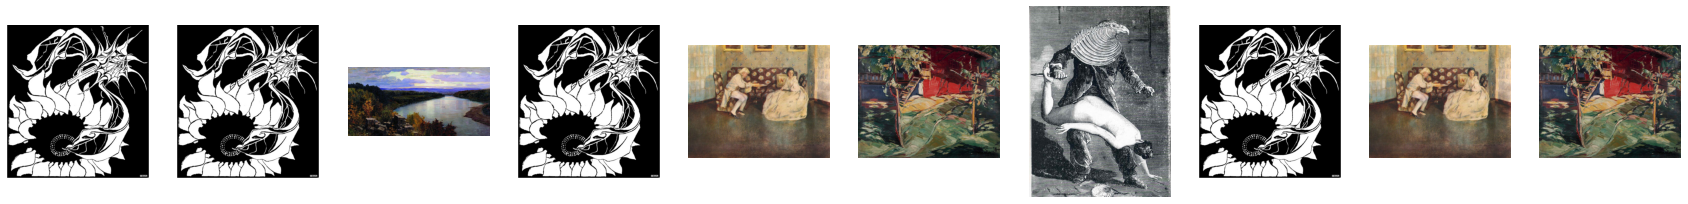

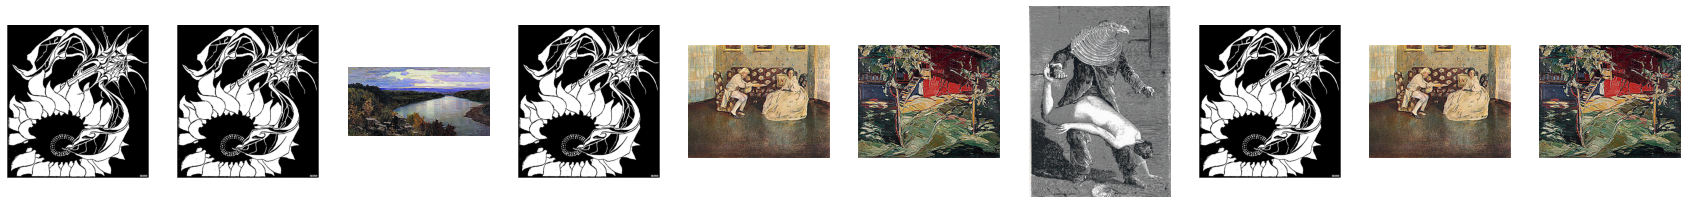

In [9]:
# Select random images
images_to_process = pick_random_images(nb_images=10, random_range=10)

# Pipeline
def pipeline_preprocess(image, pre_denoise=True):
    
    denoised_image = image
    
    # Gaussian blur
    if(pre_denoise):
        denoised_image = gaussian_blur(image)
        
    # Mexhat filter
    processed_image = apply_mexican_hat(denoised_image)
    
    return processed_image;

def preprocess_images(images):
    
    processed_images = []
    
    for image in images:
        processed_image = pipeline_preprocess(image, pre_denoise=True)
        processed_images.append(processed_image)
        
    return processed_images

processed_imgs = preprocess_images(images_to_process)

# Display Results
disp_img(images_to_process)
disp_img(processed_imgs)

In [10]:
def resize(images) :
    resized_images = []
    for img in images :
        resized = cv2.resize(img, (256,256))
        resized_images.append(resized)
    return resized_images

(256, 256, 3)

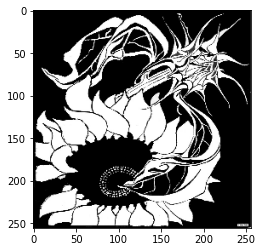

In [11]:
resized = resize([images_to_process[7]])
plt.imshow(resized[0])
resized[0].shape

# Classification

In [12]:
classifier_model = tf.keras.models.load_model(("finalBinaryModel/model"))

# Check its architecture
# new_model.summary()

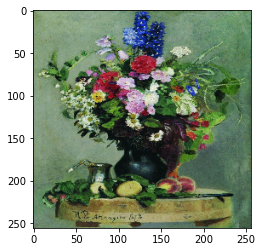

(256, 256, 3)
[[2.140318]]
photo


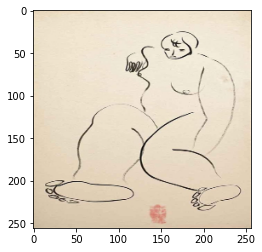

(256, 256, 3)
[[-8.739624]]
notPhoto


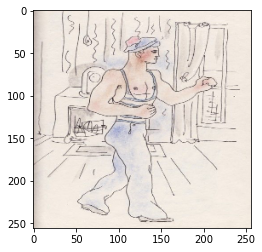

(256, 256, 3)
[[-7.463363]]
notPhoto


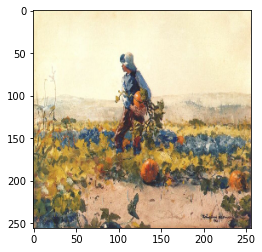

(256, 256, 3)
[[-3.675267]]
notPhoto


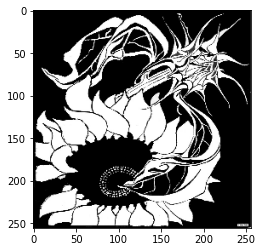

(256, 256, 3)
[[-42.55402]]
notPhoto


In [13]:
images_to_process = pick_random_images(nb_images=30, random_range=30)

for i in range(5) :
    resized = resize([images_to_process[i]])
    plt.imshow(resized[0])
    plt.show()
    print(resized[0].shape)
    is_photo_probability = classifier_model.predict(resized[0].reshape(1,256,256,3))
    # is_photo_probability = 0.68
    print(is_photo_probability)
    if is_photo_probability > 0 :
        print("photo")
    else :
        print("notPhoto")

# Le Captioner

In [14]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
features_shape = 2048
attention_features_shape = 64

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet') #poids de imageNet
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#On créer un le nouveau modèle
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

In [17]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [18]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    @tf.function
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       dropout=0.4)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.dp1 = tf.keras.layers.Dropout(0.4)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)
    @tf.function
    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru1(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        x = self.dp1(x)
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights
    @tf.function
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
def evaluate(image, decoder, encoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [21]:
encoder2 = CNN_Encoder(embedding_dim)
decoder2 = RNN_Decoder(embedding_dim, units, vocab_size)

In [22]:
encoder2.load_weights("ckpt_encod/encod2")
decoder2.load_weights("ckpt_decod/decod2")
decoder2.attention.load_weights("ckpt_decod/bahda2")

In [23]:
max_length = 20

In [24]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))# 299px/299px
    img = tf.keras.applications.inception_v3.preprocess_input(img) #normalisation
    return img, image_path

Prediction Caption: an image of water suit is riding his board <end>


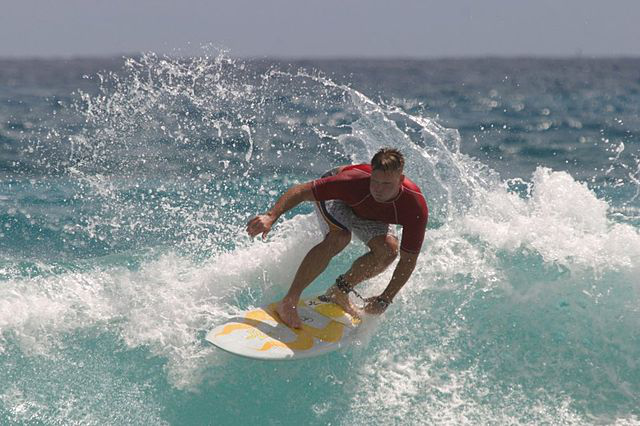

In [25]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path, decoder2, encoder2)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Création du pipleine complet

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [27]:
class ImagePreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        resized = resize([imageio.imread(X)])
        return (X, resized[0])

class Classification(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        path, resized = X
        return (path, classifier_model.predict(resized.reshape(1,256,256,3)))

class Captioning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        path, logit = X
        caption = ""
        if(logit > 0) :
            caption, _ = evaluate(path, decoder2, encoder2)
            caption = ' '.join(caption)
        else :
            caption = "This is not a photo"
        return caption



In [28]:
full_pipeline = Pipeline([
        ('preprocess', ImagePreprocessing()
        ),
        ('classif', Classification()),
        ('caption', Captioning()),
    ])

In [29]:
# full_pipeline.fit_transform(current_file)

# Test des différents pipelines

In [30]:
folder = join("dataset")
folder_path = join(os.getcwd(), folder)
#list files in folder
files = [join(folder_path, f) for f in listdir(folder_path) if isfile(join(folder_path, f))]
# print(files)

## Choix d'une image

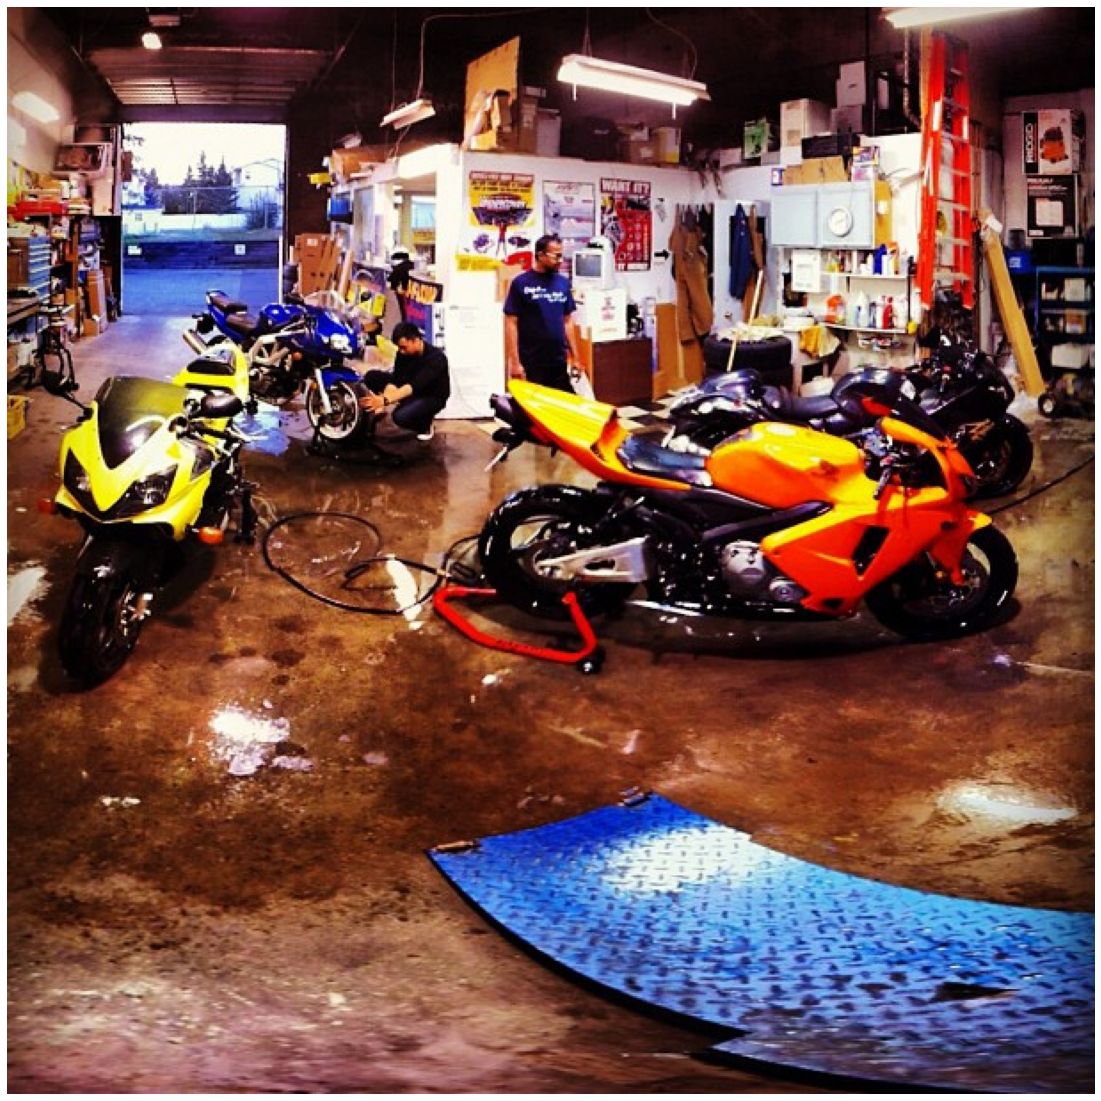

In [31]:
current_file = files[35]
disp_img([Image.open(current_file)])

## Pre-processing

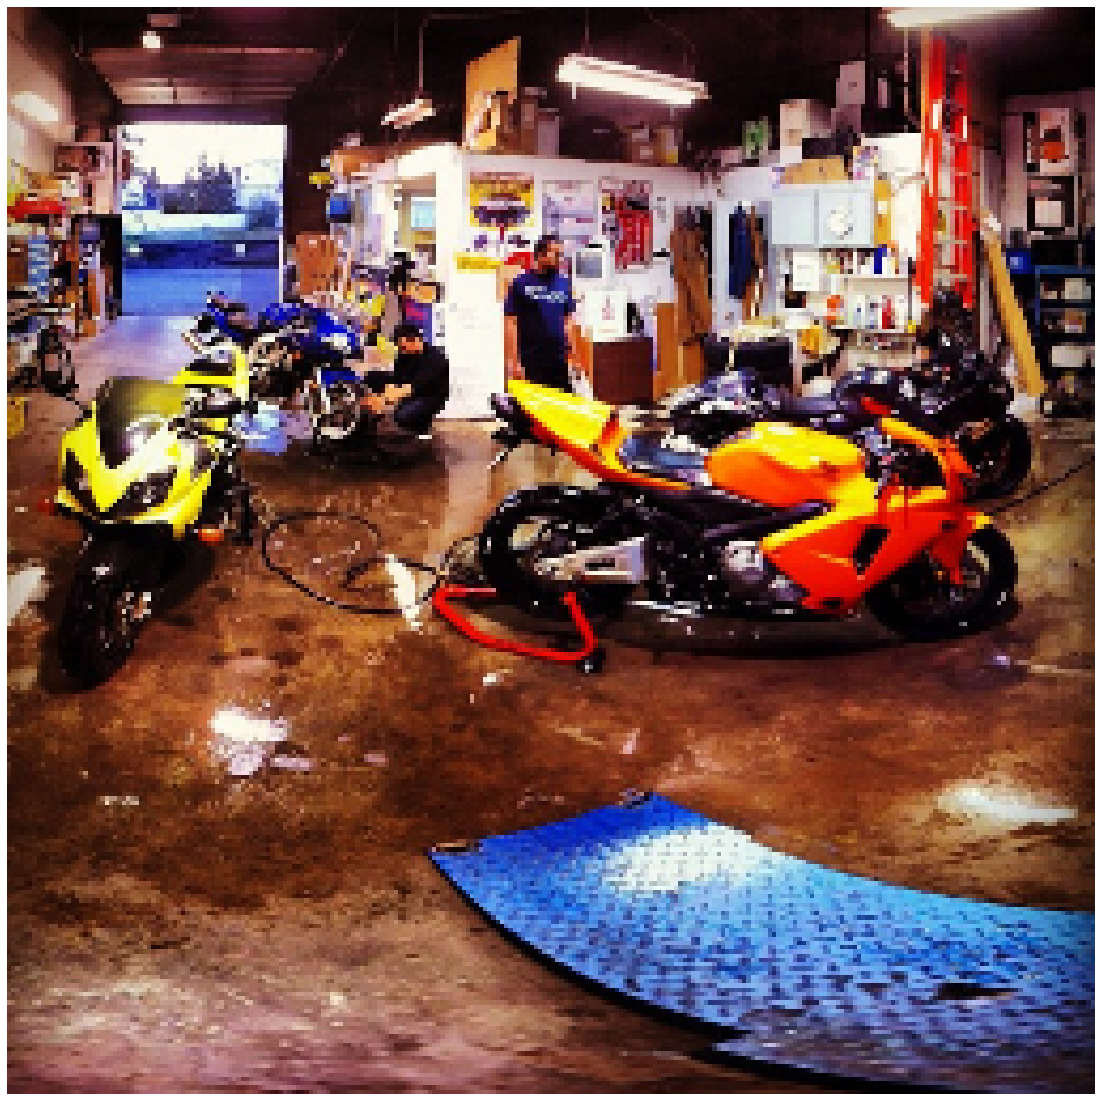

In [32]:
preprocess = ImagePreprocessing().transform(current_file)
disp_img([preprocess[1]])

## Classification

In [33]:
classif = Classification().transform(preprocess)
print(classif)

('C:\\Users\\Nico\\Data science\\livrable final\\pipelineFinal\\dataset\\photo_0117.jpg', array([[3.3189185]], dtype=float32))


## Captioning

In [34]:
caption = Captioning().transform(classif, current_file)
print(caption)

a bicycle motorcycles <end>


# Test du pipeline complet

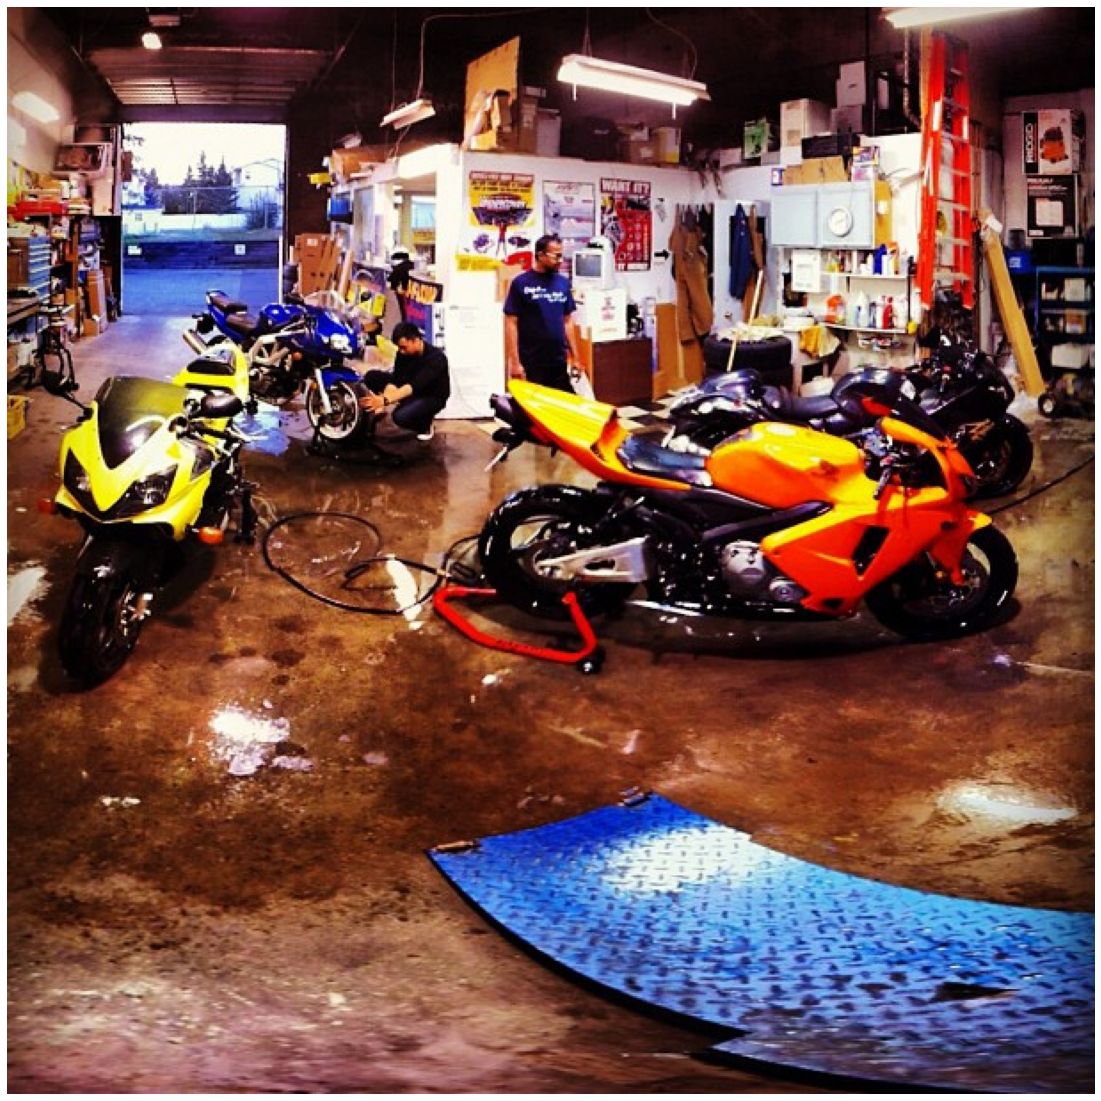

'a scooter with a bike that is sitting on a few bill boards watching <end>'

In [35]:
current_file = files[35]
disp_img([Image.open(current_file)])
full_pipeline.fit_transform(current_file)